# OpenRank x OSO | Protocol Rank

_This notebook utilizes the openrank-sdk and the Open Source Observer unified events model to generate a simple demo of a "protocol rank" algorithm._

* Learn more about how to build notebooks on top of OSO data here: https://docs.opensource.observer/docs/integrate/

* Learn more about the the openrank-sdk here: https://docs.openrank.com/openrank-sdk/installation-and-use

In [1]:
#!pip install openrank-sdk

In [2]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
from openrank_sdk import EigenTrust
import os
import pandas as pd
import seaborn as sns

In [3]:
# make sure you have your GCP credentials in order to access the database
# ... and remember never to commit these into GitHub!
# more info: https://docs.opensource.observer/docs/integrate/python-notebooks#obtain-a-gcp-service-account-key

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "../../../gcp_credentials.json"
client = bigquery.Client()

## Query the event data from OSO

In this example, we look for contributors to any of the repos in the Ethereum GitHub org space (based on commit history). These commits form our "pretrust events". Then, we identify repos of **onchain protocols** that those developers have starred or forked. These represent our "localtrust events". We return the full dataset for further transformations in Python instead of SQL.

In [4]:
query = """
    with repos as (
      select
        artifact_id as repo_id,
        artifact_name as github_repo,
        artifact_namespace as github_owner
      from `opensource-observer`.`oso`.`int_artifacts_in_ossd_by_project`
    ),
    protocols as (
      select distinct project_id
      from `opensource-observer`.`oso`.`onchain_metrics_by_project_v1`
      where transaction_count_6_months > 100
    ),
    events as (
      select
        project_id,
        from_artifact_id as dev_id,
        to_artifact_id as repo_id,
        event_type,
        bucket_month,
        amount
      from `opensource-observer`.`oso`.`int_events_monthly_to_project`
      where
        event_type in ('COMMIT_CODE','STARRED','FORKED')
        and bucket_month > '2018-01-01'
    ),
    trusted_repos as (
      select distinct repo_id
      from repos
      where github_owner = 'ethereum'
    ),
    pretrust_events as (
      select * from events
      where
        repo_id in (select repo_id from trusted_repos)
        and event_type = 'COMMIT_CODE'
    ),
    localtrust_events as (
      select * from events
      where
        dev_id in (select distinct dev_id from pretrust_events)
        and event_type in ('STARRED', 'FORKED')
        and repo_id not in (select repo_id from trusted_repos)
        and project_id in (select project_id from protocols)
    ),
    union_events as (
      select * from pretrust_events
      union all
      select * from localtrust_events
    )
    select
      e.dev_id,
      e.project_id,
      r.github_owner,
      r.github_repo,
      e.bucket_month,
      e.event_type,
      e.amount
    from union_events as e
    join repos as r on e.repo_id = r.repo_id
"""
result = client.query(query)

In [5]:
df = result.to_dataframe()
df.nunique()

dev_id          254
project_id      104
github_owner     79
github_repo     563
bucket_month     78
event_type        3
amount          270
dtype: int64

## Construct a graph from the event data

This is very simple P2P graph implementation. The edges in the network represent developers who have commited to one or more of the Ethereum repos and also starred or forked some other repo that is included in OSO. The weighting formula is the square root of the developers commits multiplied by 1 in the case of forks and 0.25 in the case of stars.

In [6]:
localtrust = []
trusted_repos = set()
for dev_id in df['dev_id'].unique():
    
    commits = (
        df[(df['dev_id']==dev_id) & (df['event_type']=='COMMIT_CODE')]
        .groupby('github_repo')['amount']
        .sum()
    )
    stars = (
        df[(df['dev_id']==dev_id) & (df['event_type']=='STARRED')]
        .groupby('github_owner')['amount']
        .sum()
    )
    forks = (
        df[(df['dev_id']==dev_id) & (df['event_type']=='FORKED')]
        .groupby('github_owner')['amount']
        .sum()
    )
    values = forks.add(stars/4, fill_value=0)
    
    for (i, commit_count) in commits.items():
        for (j, val) in values.items():
            if commit_count and val:
                v = val * np.sqrt(commit_count)
                localtrust.append({'i':i, 'j':j, 'v':v})
                trusted_repos.add(i)
            
localtrust[:5]

[{'i': 'ethereum-org-website', 'j': '0xsequence', 'v': 8.12403840463596},
 {'i': 'ethereum-org-website', 'j': 'aave', 'v': 4.06201920231798},
 {'i': 'ethereum-org-website', 'j': 'aragon', 'v': 36.55817282086183},
 {'i': 'ethereum-org-website', 'j': 'compound-finance', 'v': 8.12403840463596},
 {'i': 'ethereum-org-website',
  'j': 'ethereum-optimism',
  'v': 12.186057606953941}]

## Run EigenTrust over the graph

This example simply runs the algorithm on the P2P graph, without using a pretrust parameter.

In [7]:
a = EigenTrust()
protocol_rank = a.run_eigentrust(localtrust)
protocol_rank[:10]

INFO:root:eigentrust compute took 0.4282395000336692 secs 


[{'i': 'safe-global', 'v': 0.03625179480380721},
 {'i': 'scaffold-eth', 'v': 0.029497551309617422},
 {'i': 'ethereum-optimism', 'v': 0.02701021582992854},
 {'i': 'uniswap', 'v': 0.023091573643231608},
 {'i': 'makerdao', 'v': 0.022113538753791986},
 {'i': 'metamask', 'v': 0.013908667083592955},
 {'i': 'eth-infinitism', 'v': 0.012769386925581262},
 {'i': 'projectopensea', 'v': 0.011912952984503535},
 {'i': 'vectorized', 'v': 0.010822742578289885},
 {'i': 'gitcoinco', 'v': 0.01080226993447471}]

[Text(0.5, 0, 'OpenRank `v` value'), Text(0, 0.5, 'Project')]

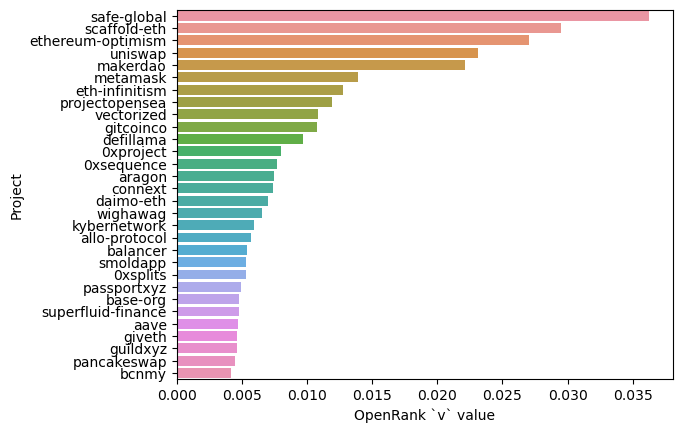

In [8]:
ax = sns.barplot(
    data=pd.DataFrame(protocol_rank[:30]),
    y='i',
    x='v',
    orient='h'
)
ax.set(xlabel='OpenRank `v` value', ylabel='Project')